In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 31.85 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [42]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import string
import random

In [6]:
# get the file path of training, testing and validation dataset

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Data preprocessing

In [7]:
# Create a function that take a filename and return a list of all lines in a file
def get_lines(filename):
  with open(filename) as f:
    return f.readlines()

In [8]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
# Number of lines
len(train_lines)

210040

In [11]:

def preprocess_text_with_line_numbers(filename):
  """
  Create a function that read file and returns a list of dictionaries of abstract line data
          [{'line_number':0,
          'target': 'BACKGROUND',
          'text': 'Emotional eating is associated with overeating and the development of obesity',
          'total_lines: 11}
        ...]
  """
  input_lines = get_lines(filename)
  returned_list = []
  lines = ""

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      lines = ""

    elif line.isspace():
      line_split = lines.splitlines()

      for line_number, line in enumerate(line_split):
        line_data = {}
        target_text_split = line.split("\t")
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1]
        line_data['line_number'] = line_number
        line_data['total_lines'] = len(line_split) - 1
        returned_list.append(line_data)

    else:
      lines += line

  return returned_list


In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 376 ms, sys: 83.7 ms, total: 460 ms
Wall time: 483 ms


(180040, 30212, 30135)

In [13]:
# Check the first samples of training set
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [14]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


In [15]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

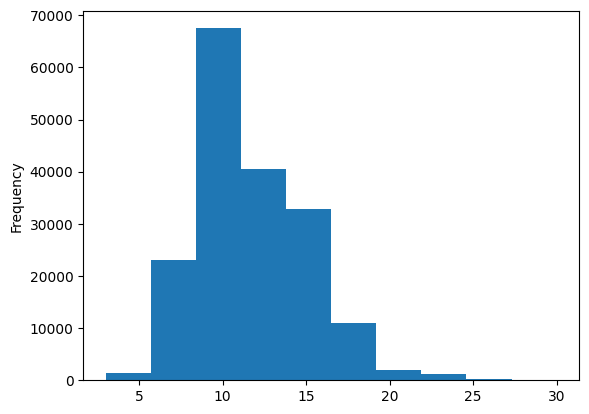

In [16]:
train_df.total_lines.plot.hist()

In [24]:
# sentences dataset
train_sentences = train_df['text'].tolist()
valid_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(valid_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [30]:
# chars dataset
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in valid_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
len(train_chars), len(valid_chars), len(test_chars)

(180040, 30212, 30135)

In [28]:
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [23]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encodedd = label_encoder.transform(test_df['target'].to_numpy())

train_labels_one_hot, train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([3, 2, 2, ..., 4, 1, 1]))

## Create tensorflow datasets for sentences and characters

In [31]:
# tensorfow dataset training
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#tensorflow dataset validation
valid_char_token_data = tf.data.Dataset.from_tensor_slices((valid_sentences, valid_chars))
valid_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
valid_char_token_dataset = tf.data.Dataset.zip((valid_char_token_data))
valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



## Create char vectorizer

In [34]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

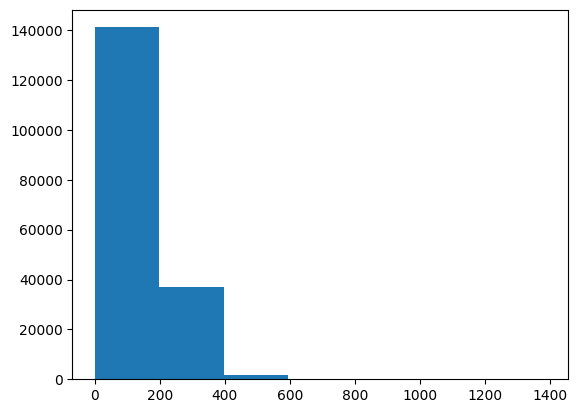

In [35]:
plt.hist(char_lens, bins=7)

In [36]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [38]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [39]:
# Create a char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                                               output_sequence_length=output_seq_char_len,
                                                                               name='char_vectorizer')

In [40]:
char_vectorizer.adapt(train_chars)

In [44]:
random_char_sample = random.choice(train_chars)
random_char_sample, char_vectorizer(random_char_sample)

('T h e   c o m b i n e d   E B U S / E U S   p r o c e d u r e   c a n   r e p l a c e   s u r g i c a l   m e d i a s t i n a l   s t a g i n g   i n   p a t i e n t s   w i t h   p o t e n t i a l l y   r e s e c t a b l e   N S C L C   .',
 <tf.Tensor: shape=(290,), dtype=int64, numpy=
 array([ 3, 13,  2, 11,  7, 15, 22,  4,  6,  2, 10,  2, 22, 16,  9,  2, 16,
         9, 14,  8,  7, 11,  2, 10, 16,  8,  2, 11,  5,  6,  8,  2, 14, 12,
         5, 11,  2,  9, 16,  8, 18,  4, 11,  5, 12, 15,  2, 10,  4,  5,  9,
         3,  4,  6,  5, 12,  9,  3,  5, 18,  4,  6, 18,  4,  6, 14,  5,  3,
         4,  2,  6,  3,  9, 20,  4,  3, 13, 14,  7,  3,  2,  6,  3,  4,  5,
        12, 12, 19,  8,  2,  9,  2, 11,  3,  5, 22, 12,  2,  6,  9, 11, 12,
        11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  

## Create a character-level embedding

In [46]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [47]:
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                       output_dim=25,
                                       mask_zero=True,
                                       name='char_embed')

In [51]:
# create a character baseline
num_classes = 5
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_char = tf.keras.Model(inputs, outputs)

model_char.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

history_model_char = model_char.fit(train_char_dataset,
                                    steps_per_epoch=int(0.1 * len(train_char_dataset)),
                                    epochs=5,
                                    validation_data=val_char_dataset,
                                    validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 6ms/step - loss: 1.2550 - accuracy: 0.4948 - val_loss: 1.0437 - val_accuracy: 0.5901
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0169 - accuracy: 0.5964 - val_loss: 0.9500 - val_accuracy: 0.6287
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9395 - accuracy: 0.6287 - val_loss: 0.8729 - val_accuracy: 0.6609
Epoch 4/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8811 - accuracy: 0.6570 - val_loss: 0.8472 - val_accuracy: 0.6612
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8645 - accuracy: 0.6612 - val_loss: 0.8187 - val_accuracy: 0.6832
